<a href="https://colab.research.google.com/github/ARL0228/arl0228.github.io/blob/main/ST456_WT2024_TemplateAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Helpful functions
Here are some functions which will be useful for the assignment.

In [3]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [4]:
# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [5]:
# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [6]:
# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [7]:
# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [8]:
# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Download data
After having loaded them to the Google Drive associated to your colab account (you can also load them manually, in that case modify the path accordingly).

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
npzfile = np.load('./drive/MyDrive/ST456_WT2024_data_assign1.npz')

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [11]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

# P1

In [33]:
# Model definition and compilation.
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Model fit. Remember to use the CPU runtime and set the seed before:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(4, (5, 5), padding='same', activation='relu', input_shape=(80,80,1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Conv2D(8, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Conv2D(16, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dense(4, activation='softmax'))

In [35]:
# Compile the model
model.compile(optimizer='sgd', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
99/99 [==============================] - 15s 146ms/step - loss: 2.0775 - accuracy: 0.4648 - val_loss: 1.8553 - val_accuracy: 0.5871
Epoch 2/20
99/99 [==============================] - 14s 143ms/step - loss: 1.7073 - accuracy: 0.6672 - val_loss: 1.7219 - val_accuracy: 0.6351
Epoch 3/20
99/99 [==============================] - 14s 143ms/step - loss: 1.5492 - accuracy: 0.7092 - val_loss: 1.6162 - val_accuracy: 0.6995
Epoch 4/20
99/99 [==============================] - 14s 141ms/step - loss: 1.4574 - accuracy: 0.7401 - val_loss: 1.4852 - val_accuracy: 0.7399
Epoch 5/20
99/99 [==============================] - 14s 140ms/step - loss: 1.3929 - accuracy: 0.7566 - val_loss: 1.3925 - val_accuracy: 0.7626
Epoch 6/20
99/99 [==============================] - 14s 140ms/step - loss: 1.3353 - accuracy: 0.7701 - val_loss: 1.3381 - val_accuracy: 0.7588
Epoch 7/20
99/99 [==============================] - 14s 144ms/step - loss: 1.2710 - accuracy: 0.7919 - val_loss: 1.2807 - val_accuracy: 0.7879

In [1]:
print(x_train.shape)
print(x_test.shape)

NameError: name 'x_train' is not defined

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 40, 40, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 20, 20, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 10, 10, 16)       

Q1 There are 84382 trainable parameters.
Before training, we do not expect the model to overfit. Factors influencing overfitting include the size of the dataset, the complexity of the model, and the regularization techniques used.  Although it has a large number of parameters, the data depth is not excessively large and there are only 4 output shapes. These can help us avoid overfitting.

Text(0.5, 0.98, 'Logistic regression')

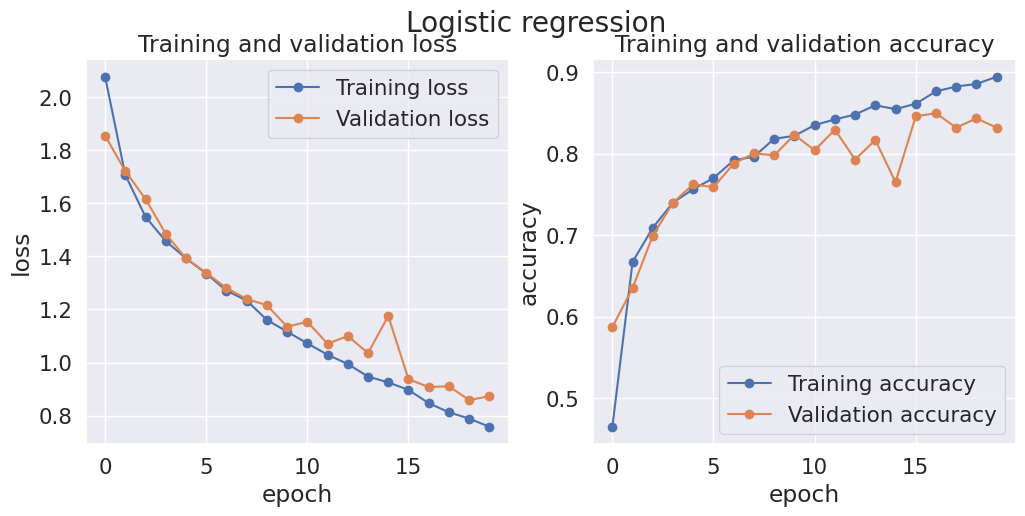

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Logistic regression')

In [45]:
# rest of P1...
# evaluate test accuracy
score_train_model = model.evaluate(x_train, y_train, verbose=0)
accuracy_train_model = 100*score_train_model[1]
print('The train accuracy is %.2f%%' % accuracy_train_model)

score_test_model = model.evaluate(x_test, y_test, verbose=0)
accuracy_test_model = 100*score_test_model[1]
print('The test accuracy is %.2f%%' % accuracy_test_model)

The train accuracy is 89.64%
The test accuracy is 84.90%


37/37 [==============================] - 2s 41ms/step


Text(0.5, 1.0, 'Test')

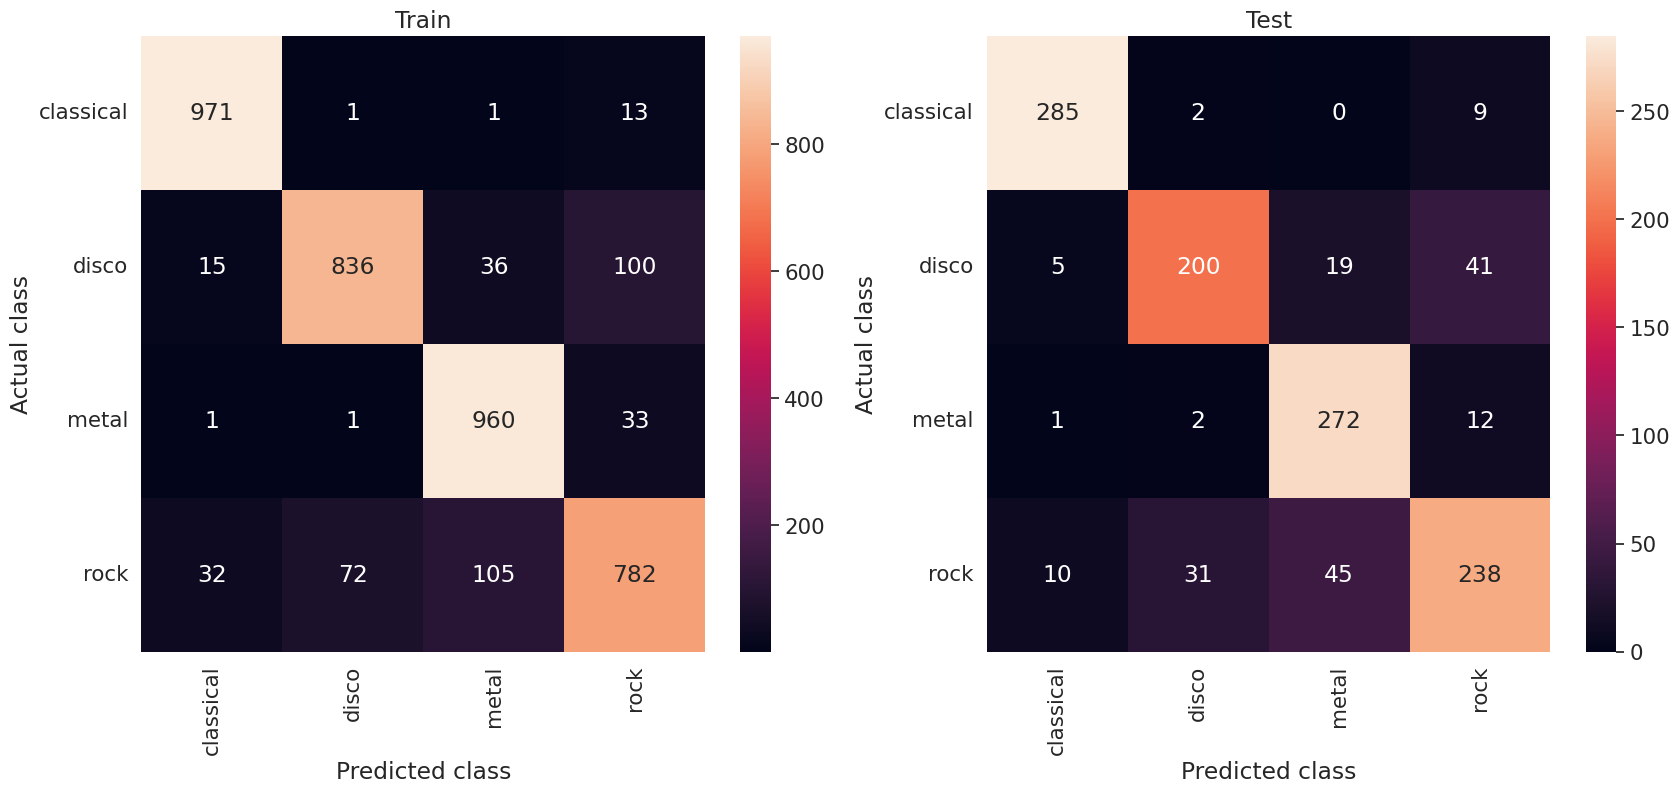

In [41]:
train_predictions = model.predict(x_train)
train_actual = np.argmax(y_train, axis=1)
train_predicted = np.argmax(train_predictions, axis=1)

test_predictions = model.predict(x_test)
test_actual = np.argmax(y_test, axis=1)
test_predicted = np.argmax(test_predictions, axis=1)

predictions = model.predict(x_test)

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plot_confusion_matrix(train_actual, train_predicted, labels=classes)
plt.title("Train")

plt.subplot(1,2,2)
plot_confusion_matrix(test_actual, test_predicted, labels=classes)
plt.title("Test")

Q4 The predictions for the classic and metal music have the highest correctness by having large numbers on the diagonal lines. It shows that most of the samples were correctly alligned. Disco could be relatively more difficult to predict, as a large number of samples are misclassified as other music types, especially as rock. This is also the case for rock as many are mispredicted as other genres.

classical spectrograms


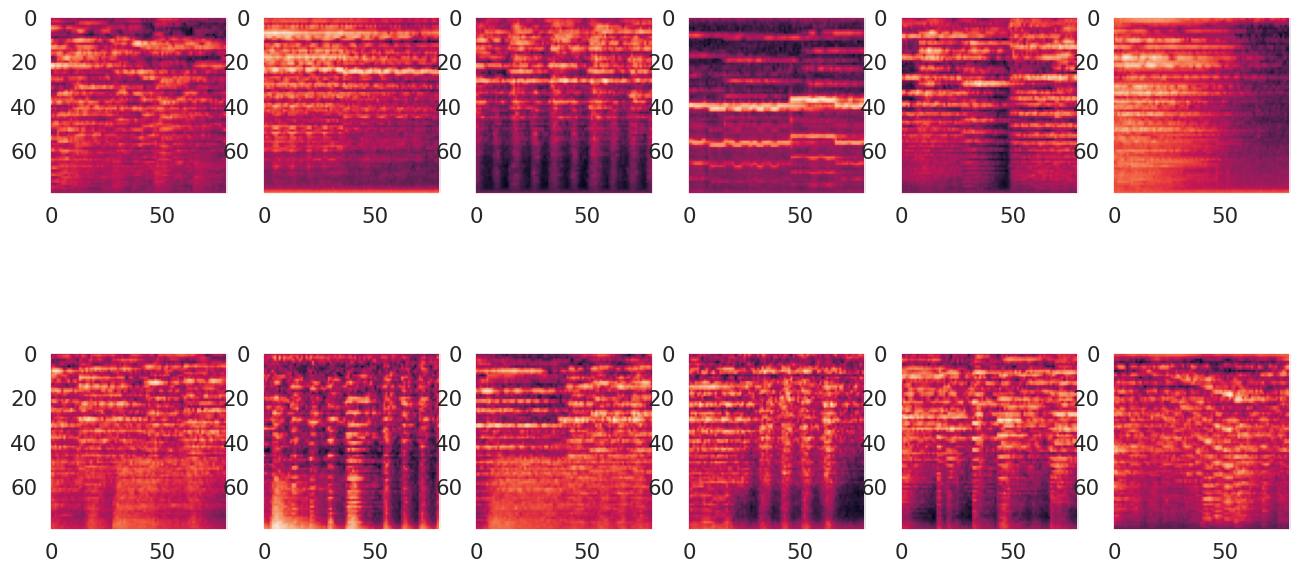

Wrongly predicted points for true class classical
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
disco spectrograms


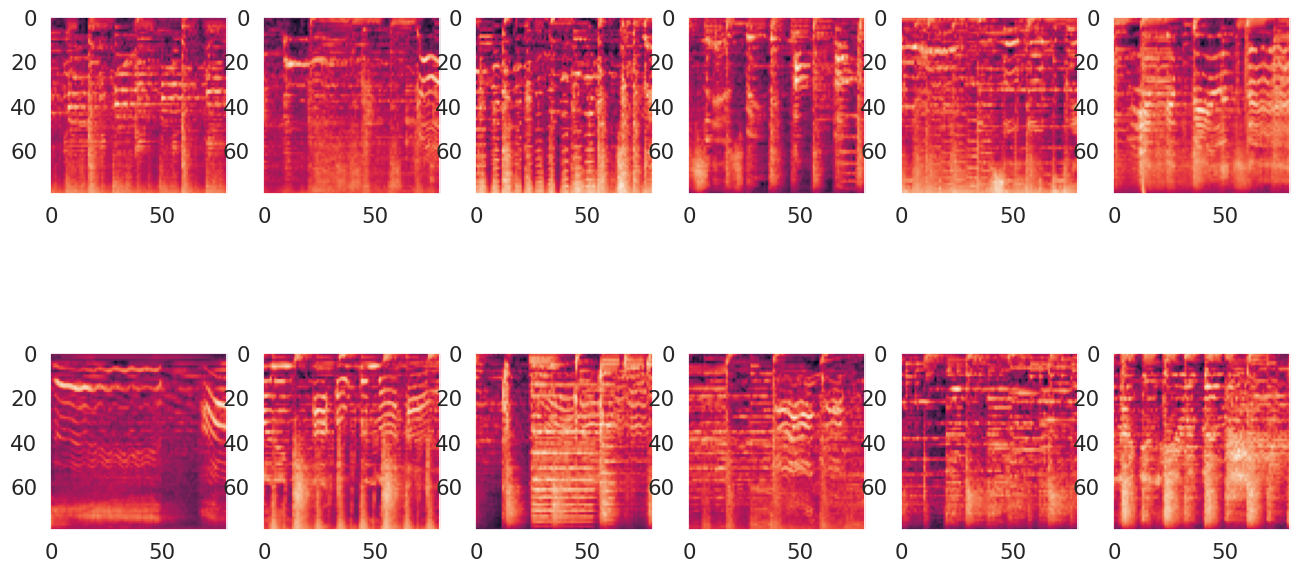

Wrongly predicted points for true class disco
predicted class is classical
predicted class is rock
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is metal
metal spectrograms


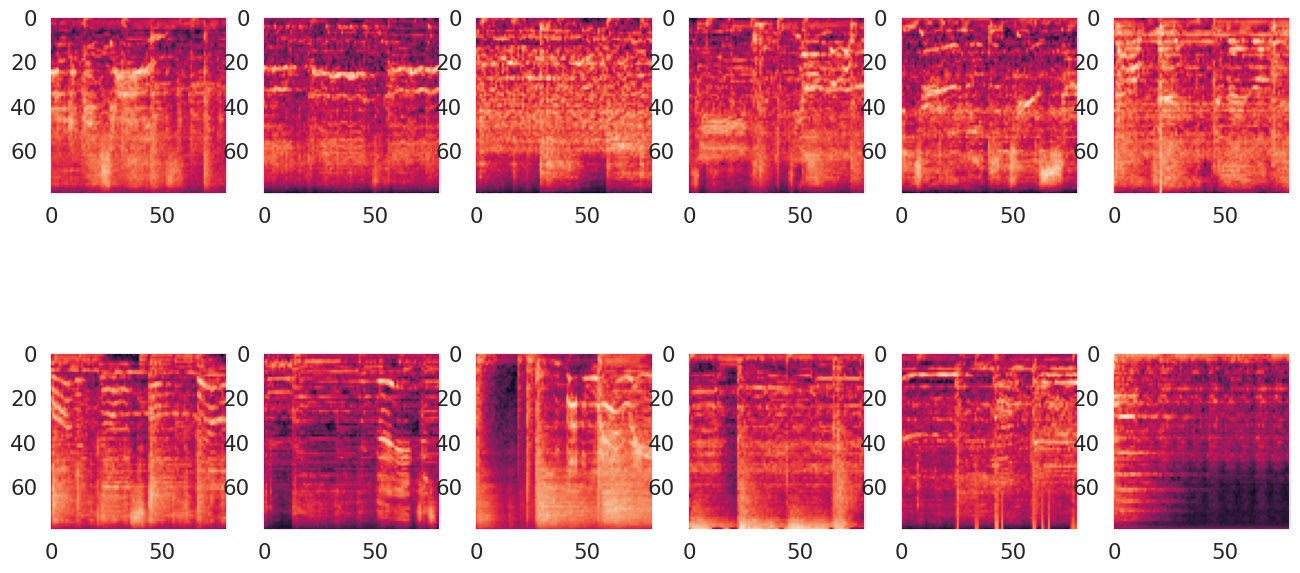

Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is classical
rock spectrograms


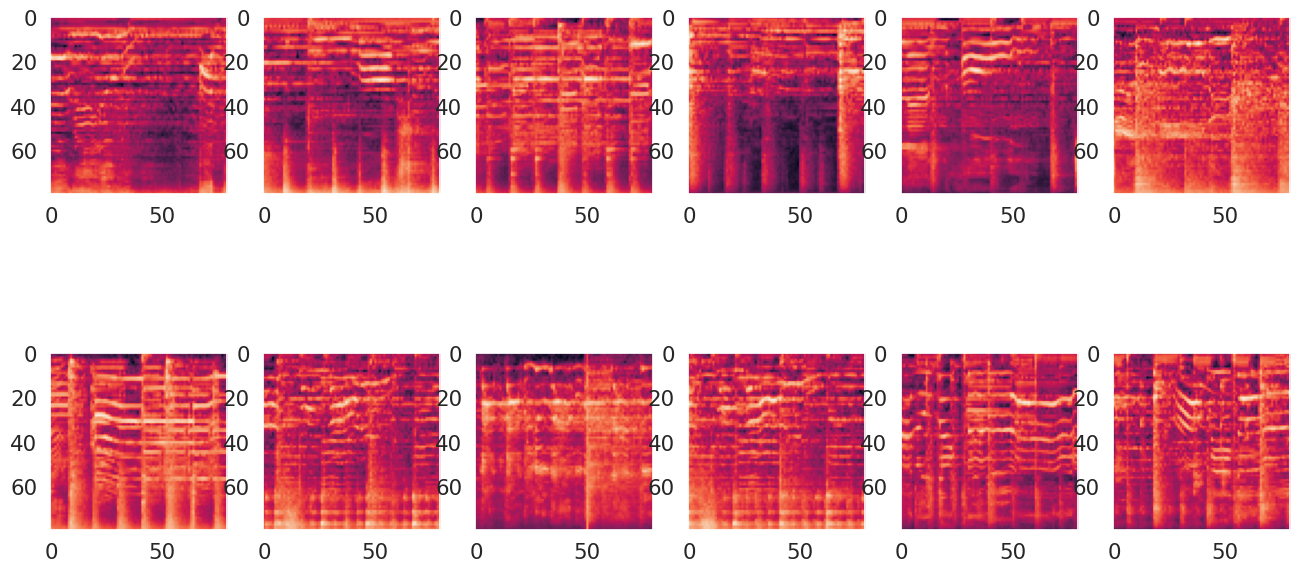

Wrongly predicted points for true class rock
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is disco


In [42]:
for genre_index, genre in enumerate(classes):
    correct_index, uncorrect_index = ind_correct_uncorrect(model, x_train, genre_index)

    correct_num = correct_index[:6]
    uncorrect_num = uncorrect_index[:6]

    print(f"{genre} spectrograms")
    plot_spectrograms(2, 6, x_train, correct_num + uncorrect_num)
    plt.show()

    print_wrong_prediction(model, x_train, y_train, uncorrect_index[:6], genre_index, classes)

Q5a
The correct predicted Mel spectrograms show that rock and disco have clear rhythms, with disco having a stronger beat. The rhythmic pattern of incorrect predictions for both genres are similar. This shared pattern may explain why the model misidentifies disco and rock. Metal has distinct regional energy distribution characteristics and a more chaotic distribution of sound. And classical has stable ripples.

classical Grad-CAM heatmaps


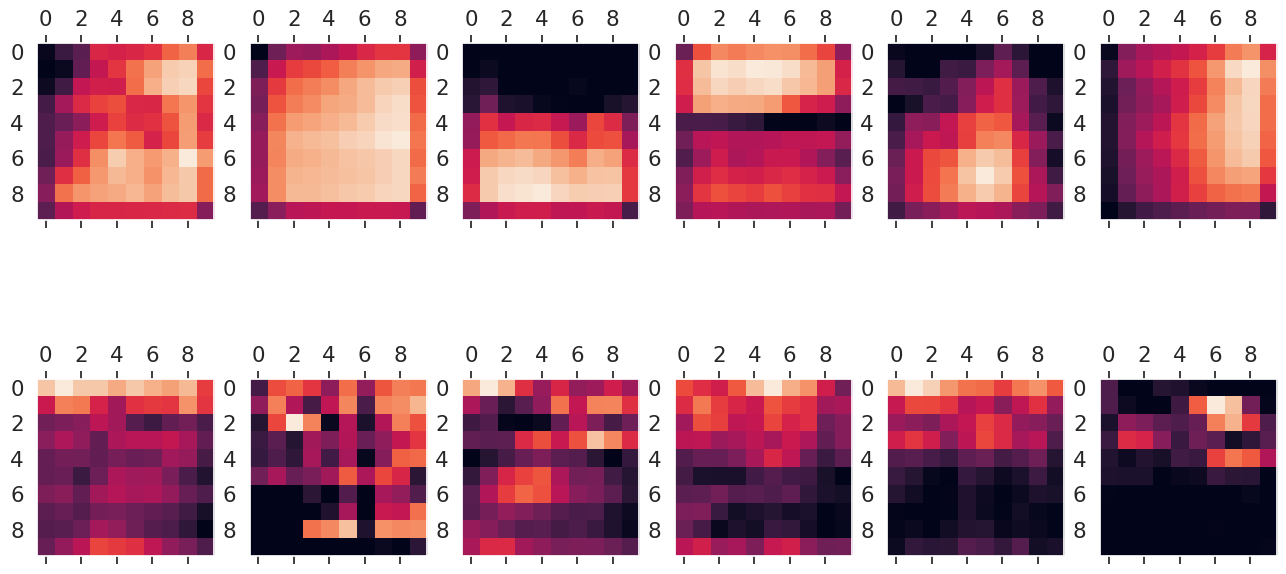

disco Grad-CAM heatmaps


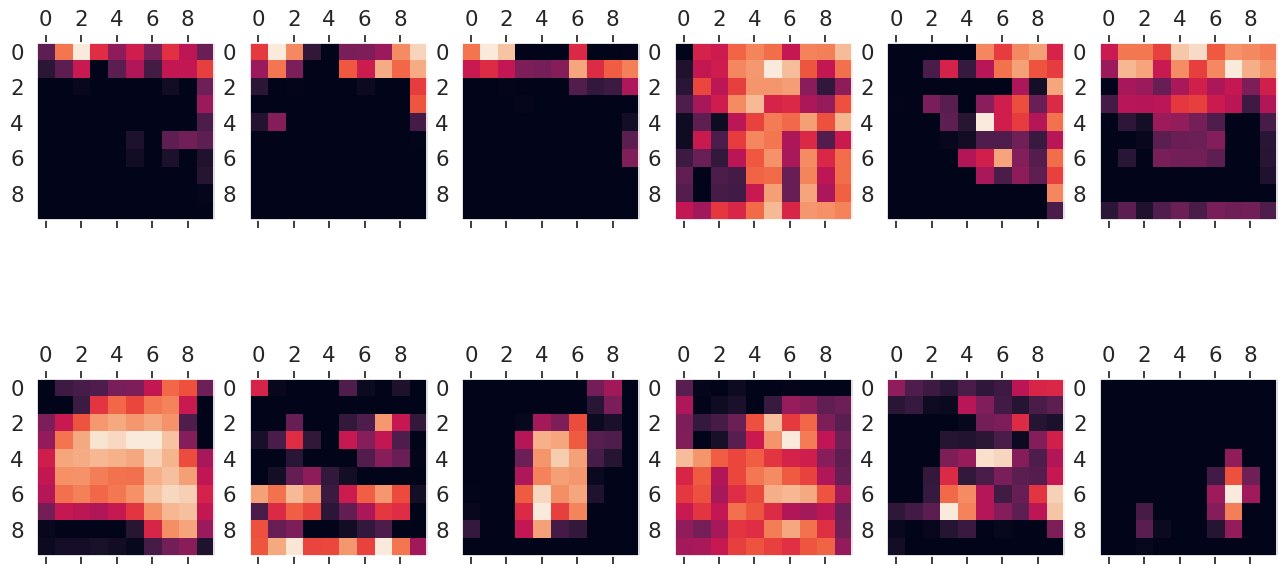

metal Grad-CAM heatmaps


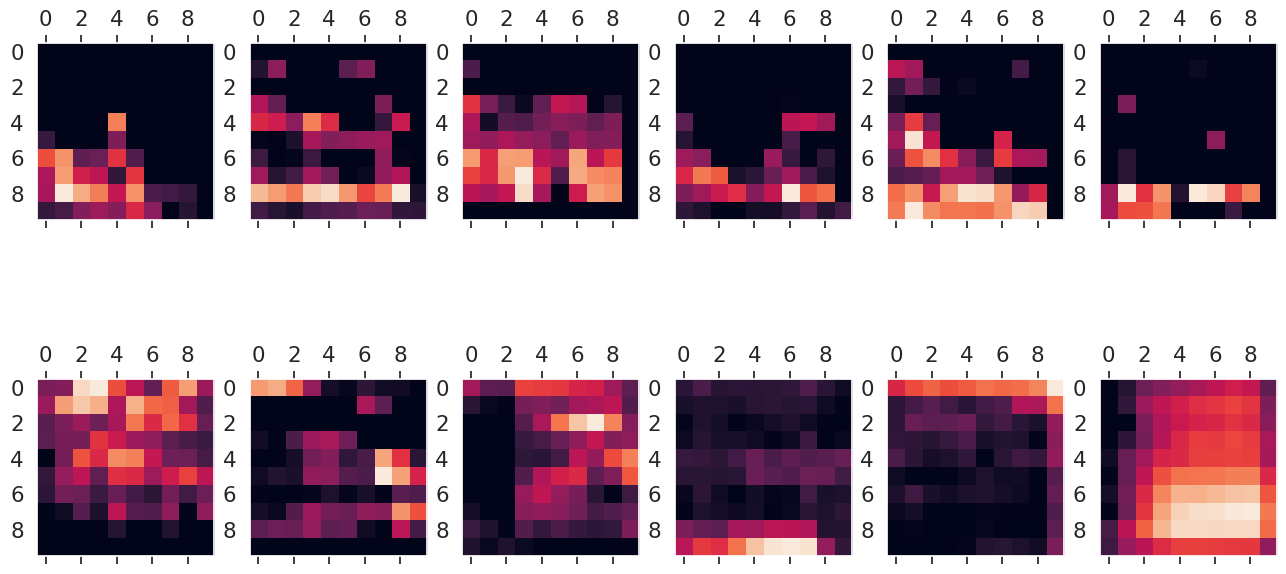

rock Grad-CAM heatmaps


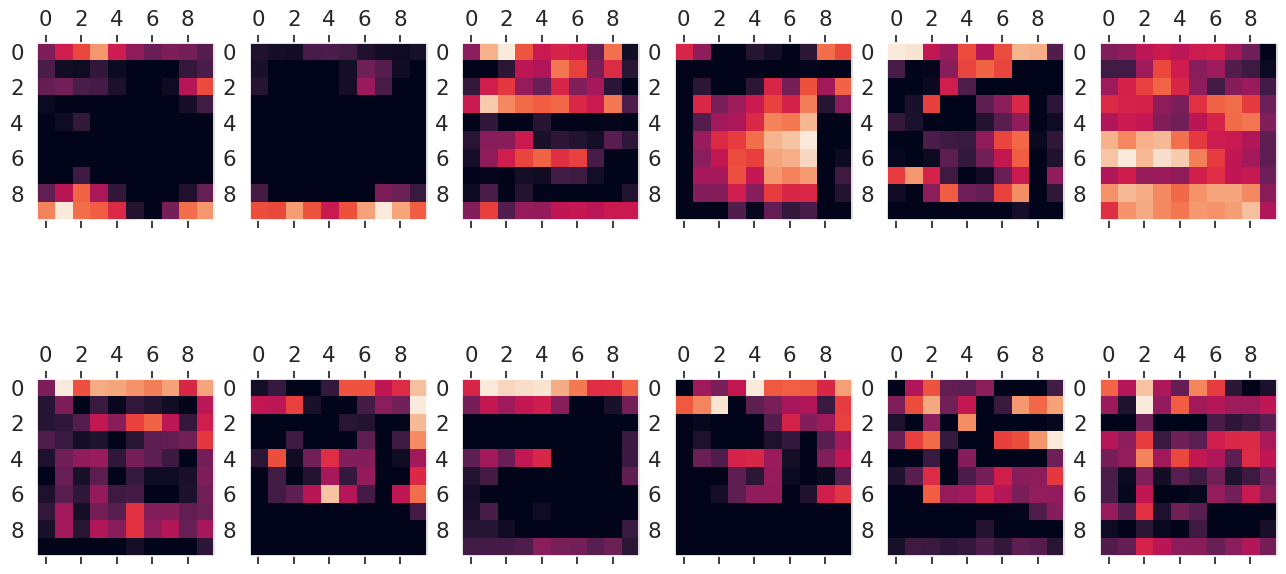

In [42]:
for genre_index, genre in enumerate(classes):
    correct_index, uncorrect_index = ind_correct_uncorrect(model, x_train, genre_index)

    correct_plot = correct_index[:6]
    uncorrect_plot = uncorrect_index[:6]

    print(f"{genre} Grad-CAM heatmaps")
    plot_gradcam_spectrogram(2, 6, x_train, correct_plot + uncorrect_plot, model, 'max_pooling2d_8')
    plt.show()

Q5c
Accurately predicted heatmaps for all music genres tend to show more highlighted regions, signifying that the model has successfully identified a larger number of features during precise predictions. On the contrary, several incorrectly predicted heatmaps, such as those associated with classical and disco genres, revealed only a limited number of identified features, leaving a large amount of dark areas.

Classical: Most part of the heatmaps are activated across most frequencies and with strong intensity, meaning that it has a very concentrated activated area, where this part is likely to be consistent over time.

Disco: It varies a lot as it could either have a small or a large activated part and can happen in any frequency. It concentrates on either low frequencies or all frequencies.

Metal: It tends to have little activated area but with high intensity in its heatmaps. But they are not consistent over time and the areas are mostly observed in high frequency parts.

Rock: It has a wide range of activated regions over the entire heatmap, similar to classical. It is observed that most highlighted areas do not have a strong intensity from the correct predictions. The difference between disco and rock is that rock's highlights are observed in both low and high frequencies, but disco is more likely to concentrate on low frequencies.

The lack of distinguishable characteristics in rock can help explain why the model is likely to wrongly predict it. And for classical being sometimes get mixed up with disco, it can be explained by the large highlighted area in the low frequencies in the classical heatmaps, which is clear with high intensity. And disco concentrates on low frequencies the most.

There are many reasons why the model made incorrect predictions: Nonconsistency in the activated areas may suggest the model could be too generalized by only focusing on common features like frequency and time across genres rather than distinctive ones. Not all essential features are fully captured(e.g. instrument, voice and edit) which makes these genres not as unique when identifying, causing errors in classification.

Q6: Due to the generally harmonic complex structure, balanced phrases and graceful melodies, it is expected that classical has a wide and consistent area of activation in the heatmap where most areas are covered. Classical music includes a wide range of frequencies, from low frequency(bass) to high frequency(treble). And a wide range of musical instruments are used when playing classical music. And the collaboration and shift in instrument would result in change in frequency. In addition, disco might has more bass lines, which concentrates on low frequency or all frequencies. might show a more concentrated pattern of activation, hence reflecting its rhythmic nature. For metal, it has fewer but more intense highlighted areas of activation. The heat map shows that the main active area of metal music is the high frequency part, or treble part. As metal genre is usually sharper in noise and highly intensive fast guitar playing as well as the use of drums.

Rock music's heatmap might display a wide range of highlighted patterns. There is no distinguishing feature and most highlighted areas do not have a strong intensity, reflecting the genre's dynamic range. In some occasions, it has only a small area of activation focusing on high frequencies. But activations can also be observed on middle or low frequencies in other heatmaps. This might because that rock music has diverse structures and styles. For example, blue, jazz and hard rocks are completely different in performance.

Using spectrograms to represent music has a high degree of complexity and there are limitations. The Grad-Cam method tends to deal with images and is more accurate when dealing with static data, not audio files. So due to the highly complex nature of music, it is likely that some important features will be lost during the process. For instance, only some of the features, such as frequency and time are included in Mel spectrograms. Different music can have completely different structures but similarities can still exist, and thus, it cannot be recognized when using the Grad-Cam method, thus the genres cannot be accurately distinguished. The model could be a general model where other important information in music might be left out. Misclassification may occur if the model focuses on non-distinctive features that are shared across genres or fails to capture the unique elements. So if the model is not trained well, the Grad-CAM heatmaps might not be as helpful.


# P2

Epoch 1/20
124/124 [==============================] - 68s 539ms/step - loss: 2.3348 - accuracy: 0.5989 - val_loss: 1.1515 - val_accuracy: 0.7100
Epoch 2/20
124/124 [==============================] - 48s 389ms/step - loss: 0.9782 - accuracy: 0.6891 - val_loss: 0.8449 - val_accuracy: 0.7503
Epoch 3/20
124/124 [==============================] - 51s 415ms/step - loss: 0.7946 - accuracy: 0.7254 - val_loss: 0.6930 - val_accuracy: 0.7814
Epoch 4/20
124/124 [==============================] - 53s 429ms/step - loss: 0.6983 - accuracy: 0.7651 - val_loss: 0.6648 - val_accuracy: 0.7975
Epoch 5/20
124/124 [==============================] - 54s 434ms/step - loss: 0.6639 - accuracy: 0.7833 - val_loss: 0.6084 - val_accuracy: 0.8308
Epoch 6/20
124/124 [==============================] - 50s 404ms/step - loss: 0.6193 - accuracy: 0.8098 - val_loss: 0.5832 - val_accuracy: 0.8343
Epoch 7/20
124/124 [==============================] - 52s 417ms/step - loss: 0.6134 - accuracy: 0.8111 - val_loss: 0.6419 - val_ac

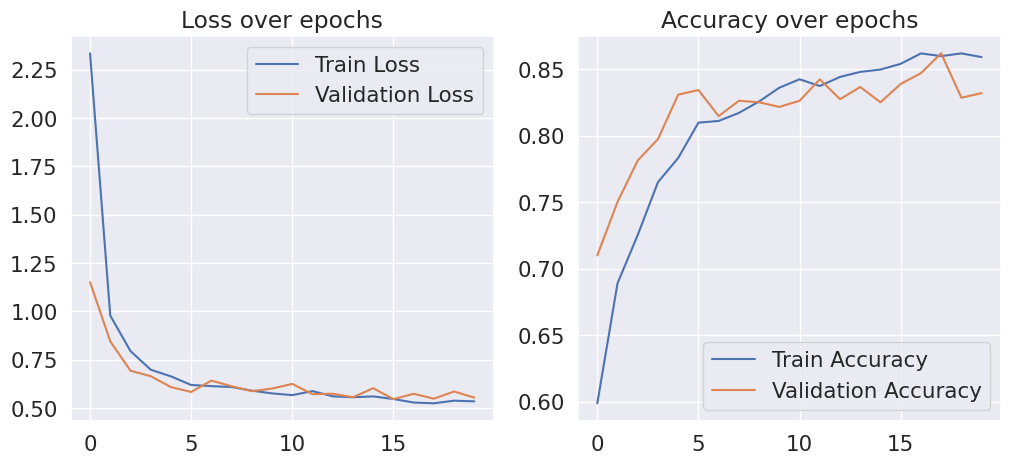

In [37]:
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2

input_shape = (80, 80, 1)
inputs = Input(shape=input_shape)
l2_reg = l2(0.01)

time_conv = Conv2D(32, (3, 1), padding='same', activation='relu')(inputs)
time_conv = MaxPooling2D((2, 2))(time_conv)
time_conv = Dropout(.5)(time_conv)

freq_conv = Conv2D(32, (1, 3), padding='same', activation='relu')(inputs)
freq_conv = MaxPooling2D((2, 2))(freq_conv)
freq_conv = Dropout(.5)(time_conv)

conc = Concatenate()([time_conv, freq_conv])

x = Conv2D(64, (3, 3), activation='relu')(conc)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2_reg)(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

In [38]:
score_train = model2.evaluate(x_train, y_train, verbose=0)
accuracy_train = 100*score_train[1]
print('The train accuracy is %.2f%%' % accuracy_train)

score_test = model2.evaluate(x_test, y_test, verbose=0)
accuracy_test = 100*score_test[1]
print('The test accuracy is %.2f%%' % accuracy_test)

The train accuracy is 91.41%
The test accuracy is 84.56%


37/37 [==============================] - 3s 82ms/step


Text(0.5, 1.0, 'Test')

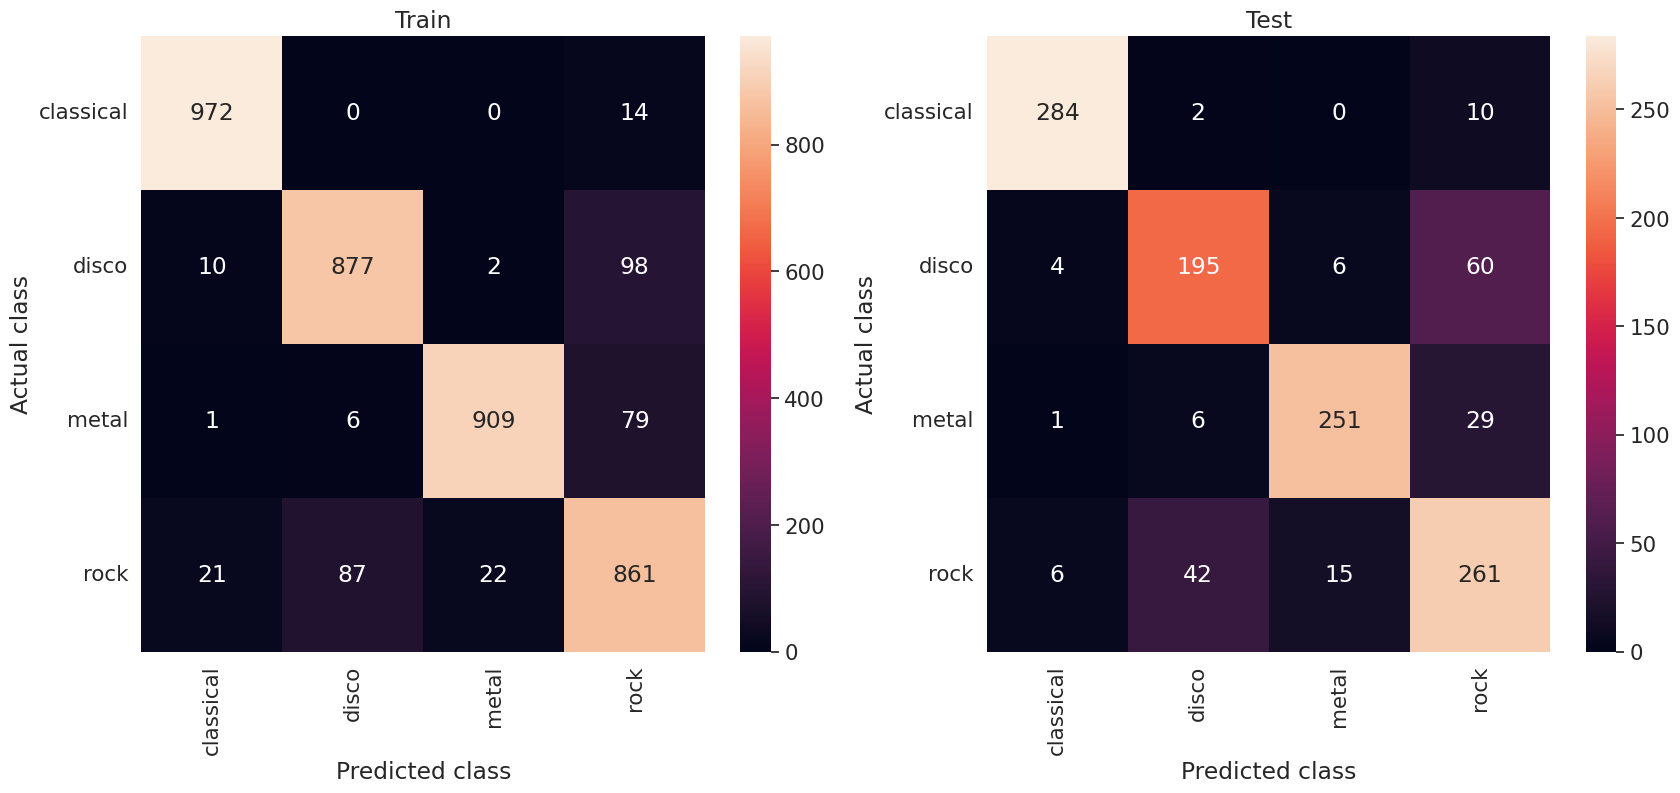

In [39]:
train_predictions2 = model2.predict(x_train)
train_actual_labels2 = np.argmax(y_train, axis=1)
train_predicted_labels2 = np.argmax(train_predictions2, axis=1)

test_predictions2 = model2.predict(x_test)
test_actual_labels2 = np.argmax(y_test, axis=1)
test_predicted_labels2 = np.argmax(test_predictions2, axis=1)

predictions2 = model2.predict(x_test)

plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plot_confusion_matrix(train_actual_labels2, train_predicted_labels2, labels=classes)
plt.title("Train")

plt.subplot(1,2,2)
plot_confusion_matrix(test_actual_labels2, test_predicted_labels2, labels=classes)
plt.title("Test")